In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory, save_datasummary_and_results
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Optionally, set memory growth to avoid allocating all memory on the GPU at once
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Actions/DATA/1D_TRANSF_SPEED_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 0] # 5?
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 4]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

import tensorflow as tf

WS_B = 1800  # Example sequence length
input_shape1 = (WS_B, 1)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 2)
input_shape4 = (WS_B, 2)

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-10-29 20:45:01.280008: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 20:45:01.308175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 20:45:01.726064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (465, 1800, 9)
y_data shape: (465,)
X_data.[0] shape:  (1800, 9)
y_data.[0] max:  3.0
TOTAL DATA: 465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (279, 1800, 9)    ||  Dimensions of y_train: (279,)
Dimensions of X_test:  (93, 1800, 9)    ||  Dimensions of y_test:  (93,)
Dimensions of X_val:   (93, 1800, 9)    ||  Dimensions of y_val:   (93,)
Shapes of the stacked arrays:
X_train1 shape: (279, 1800)
X_train2 shape: (279, 1800)
X_train3 shape: (279, 1800, 2)
X_train4 shape: (279, 1800, 2)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


2024-10-29 20:45:02.057648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:45:02.057812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:45:02.082953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 2 CONV like EASY_F+F

2024-10-29 20:45:02.211585: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:45:02.211786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:45:02.211903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 256)       │          0 │ conv1d_3_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_4_1           │ (None, 256)       │          0 │ conv1d_4_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ gap1d_1_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ gap1d_2_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 256)       │          0 │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 256)       │          0 │ gap1d_4_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 622,404 (2.37 MB)

 Trainable params: 622,404 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1730231103.157951 1719179 service.cc:145] XLA service 0x7fd394004310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730231103.157973 1719179 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-10-29 20:45:03.186327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 20:45:03.323027: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3750 - loss: 1.4066

I0000 00:00:1730231104.211977 1719179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.4297 - loss: 1.2698 - val_accuracy: 0.7312 - val_loss: 0.8784
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.7390 - val_accuracy: 0.8495 - val_loss: 0.5851
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7614 - loss: 0.5999 - val_accuracy: 0.8602 - val_loss: 0.4844
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7081 - loss: 0.6881 - val_accuracy: 0.8172 - val_loss: 0.4971
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.4166 - val_accuracy: 0.8495 - val_loss: 0.4300
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8555 - loss: 0.4245 - val_accuracy: 0.8817 - val_loss: 0.2969
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.4001 - val_accuracy: 0.8602 - val_loss: 0.3304
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3730 - val_accuracy: 0.8280 - val_loss: 0.5241
Epoch 9/70
9/9 ━━

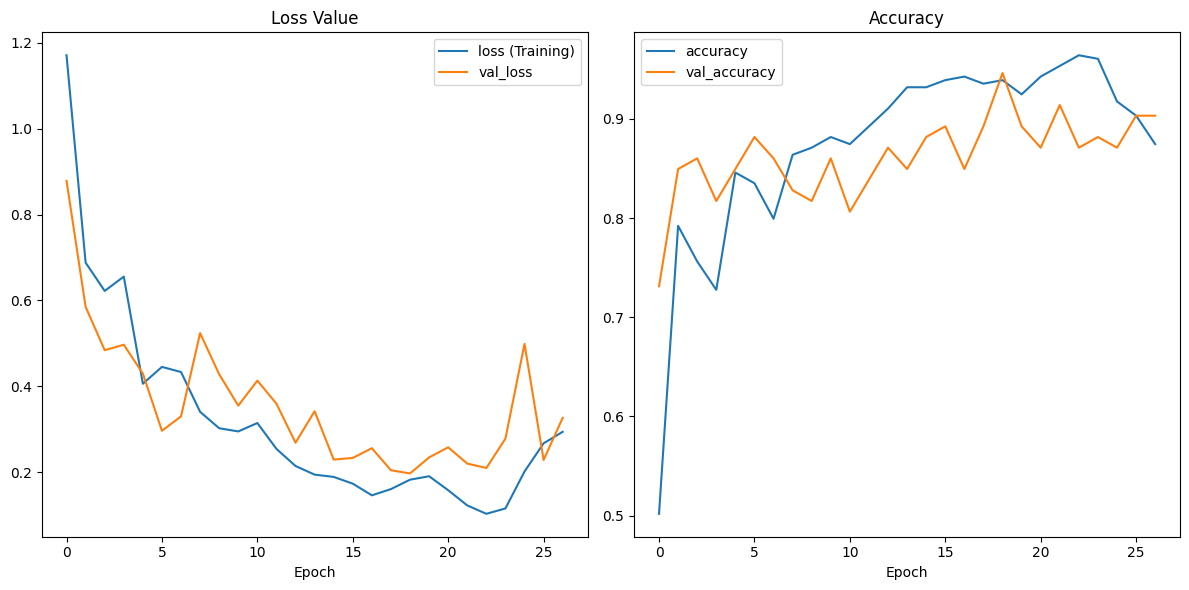

Test loss: 0.1457822024822235
Test accuracy: 0.9354838709677419
F1 Score: 0.9318000282745459
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        29
         1.0       0.88      1.00      0.94        22
         2.0       1.00      0.95      0.98        22
         3.0       0.85      0.85      0.85        20

    accuracy                           0.94        93
   macro avg       0.93      0.93      0.93        93
weighted avg       0.94      0.94      0.94        93



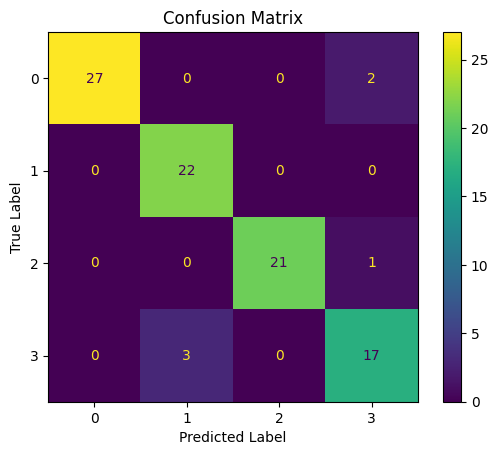

In [2]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    x1 = Flatten()(x1)
        # it was GlobalAveragePooling1D
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    x2 = Flatten()(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    x3 = Flatten()(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    x4 = Flatten()(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [3]:
# model_name = "1DComb_LDGscal_2Cnv_40krnl_8patienc_1Dns_ConfMatr_99"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

y_pred: 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


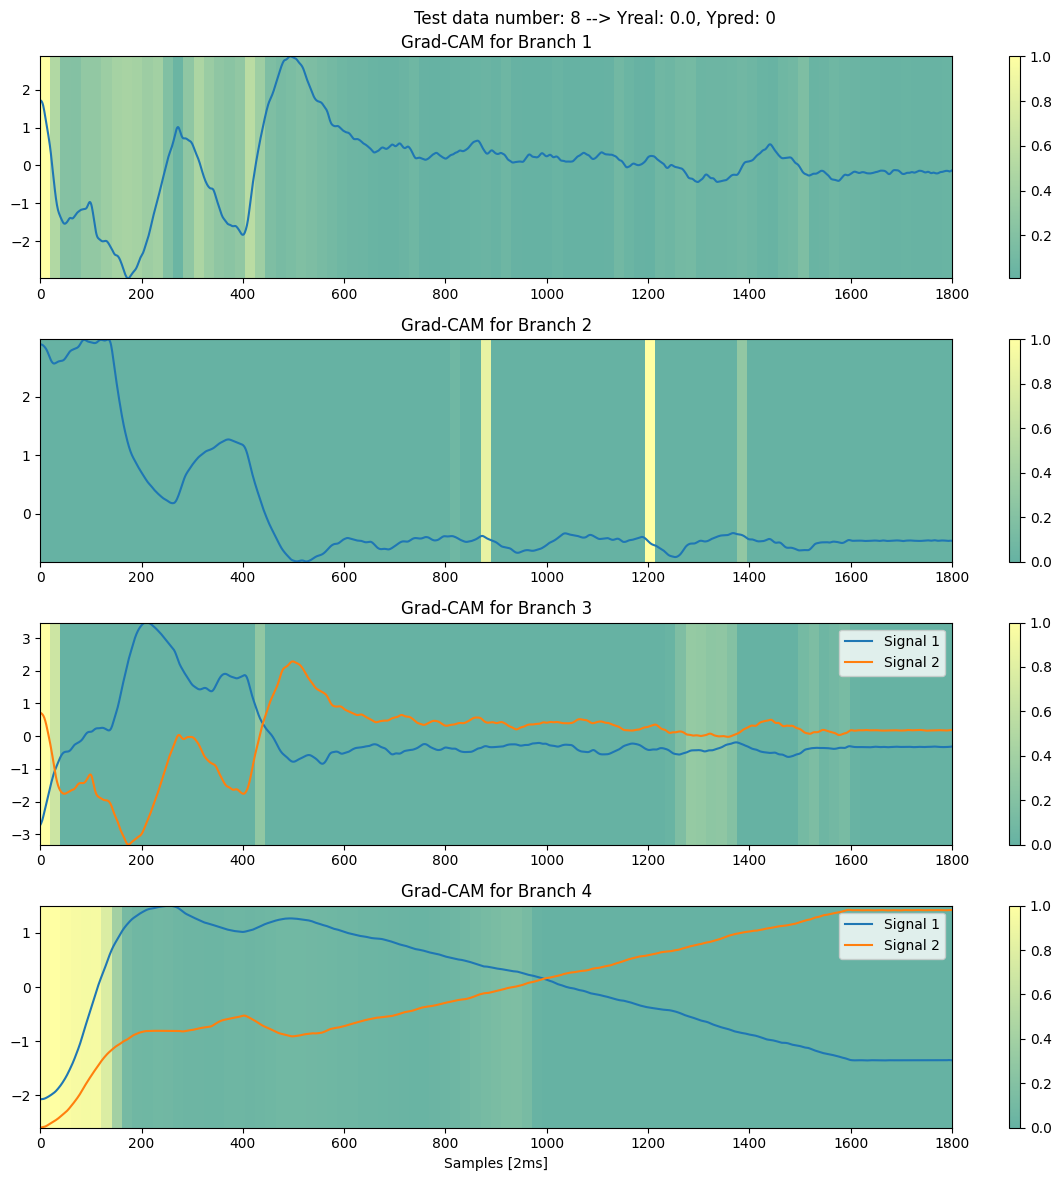

In [4]:
print(f"y_pred: {y_pred_labels[8]}")
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 8, y_test, ['conv1d_1_2', 'conv1d_2_2', 'conv1d_3_2', 'conv1d_4_2'])

# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 87, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 87, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 87, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 87, 256)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 86, 512)   │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 86, 128)   │     65,664 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 86, 512)   │    262,656 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 86, 128)   │     65,664 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 1,819,716 (6.94 MB)

 Trainable params: 1,819,716 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.2868 - loss: 1.5048 - val_accuracy: 0.4624 - val_loss: 1.2337
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5008 - loss: 1.1682 - val_accuracy: 0.4516 - val_loss: 1.0128
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5888 - loss: 0.8892 - val_accuracy: 0.6667 - val_loss: 0.8410
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6808 - loss: 0.7287 - val_accuracy: 0.7849 - val_loss: 0.6026
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6991 - loss: 0.6480 - val_accuracy: 0.7957 - val_loss: 0.5440
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7850 - loss: 0.5232 - val_accuracy: 0.7419 - val_loss: 0.5322
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7734 - loss: 0.5785 - val_accuracy: 0.7204 - val_loss: 0.6912
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7394 - loss: 0.5767 - val_accuracy: 0.8280 - val_loss: 0.4457
Epoch 9/70
9/9 ━━

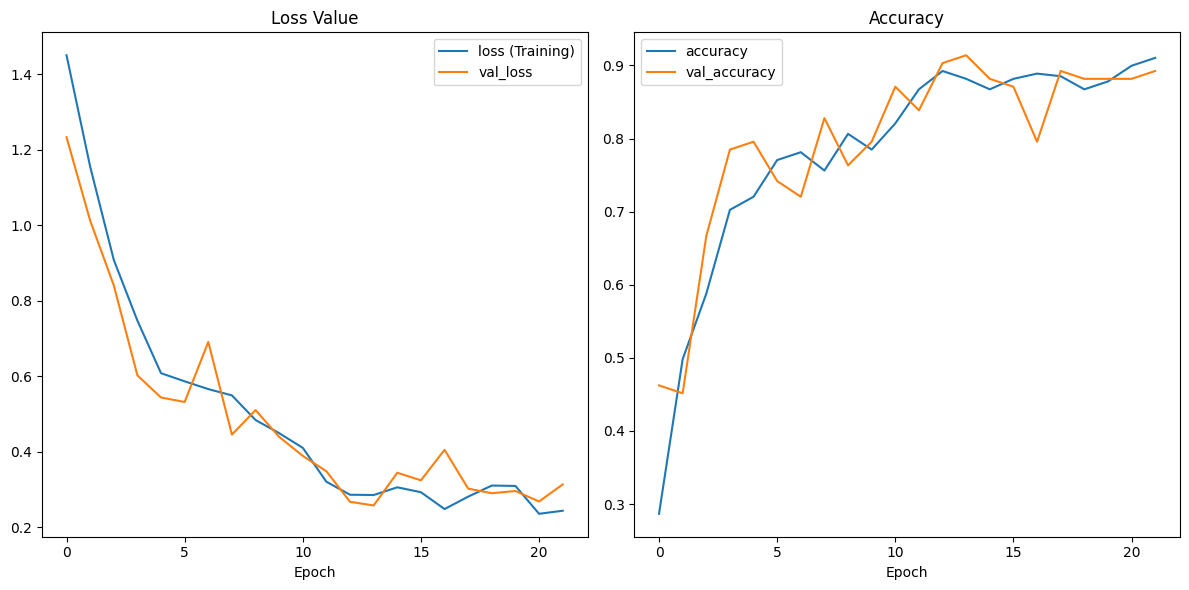

Test loss: 0.18036328256130219
Test accuracy: 0.9032258064516129
F1 Score: 0.8904059449866903
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        29
         1.0       0.92      1.00      0.96        22
         2.0       0.81      1.00      0.90        22
         3.0       0.87      0.65      0.74        20

    accuracy                           0.90        93
   macro avg       0.90      0.90      0.89        93
weighted avg       0.91      0.90      0.90        93



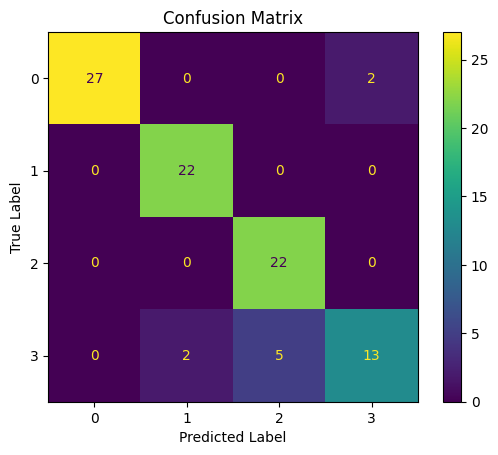

In [5]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [6]:
# model_name = "MOD_AUG_SPEED_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3Conv 93% acheived

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 90, 128)   │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 90, 128)   │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 90, 128)   │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 90, 128)   │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_1       │ (None, 45, 128)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_1       │ (None, 45, 128)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_1       │ (None, 45, 128)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_4_1       │ (None, 45, 128)   │          0 │ conv1d_4_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_3_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_4_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 10, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 10, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 10, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 10, 256)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 9, 256)    │    131,328 │ dropout_1_1[0][0

 Total params: 1,450,436 (5.53 MB)

 Trainable params: 1,450,436 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 470ms/step - accuracy: 0.3730 - loss: 1.3219 - val_accuracy: 0.5269 - val_loss: 1.1212
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6218 - loss: 0.9701 - val_accuracy: 0.7204 - val_loss: 0.7191
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7202 - loss: 0.7125 - val_accuracy: 0.8387 - val_loss: 0.4007
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - loss: 0.4829 - val_accuracy: 0.8710 - val_loss: 0.3652
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.4502 - val_accuracy: 0.8602 - val_loss: 0.3493
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8881 - loss: 0.3075 - val_accuracy: 0.7312 - val_loss: 0.5054
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8183 - loss: 0.4332 - val_accuracy: 0.8710 - val_loss: 0.3176
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3736 - val_accuracy: 0.8817 - val_loss: 0.2562
Epoch 9/70
9/9 ━━

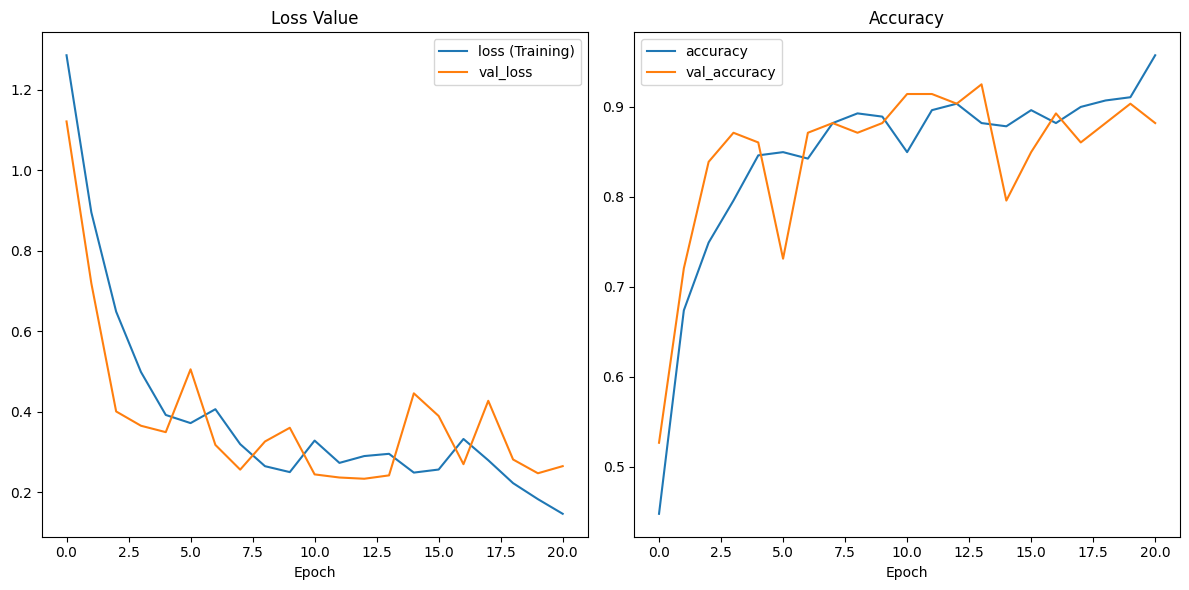

Test loss: 0.2076709270477295
Test accuracy: 0.9139784946236559
F1 Score: 0.9083172003979457
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        29
         1.0       0.81      1.00      0.90        22
         2.0       0.92      1.00      0.96        22
         3.0       0.94      0.75      0.83        20

    accuracy                           0.91        93
   macro avg       0.92      0.91      0.91        93
weighted avg       0.92      0.91      0.91        93



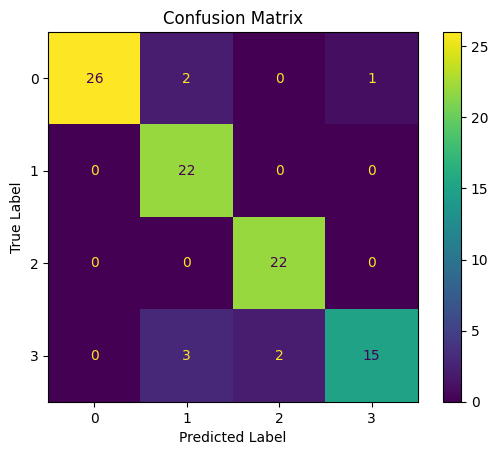

In [7]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = MaxPooling1D(pool_size=2, name='maxpool1d_4_1')(x4)
    x4 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [8]:
# model_name = "1D_AUGstr_SPEED_3Cnv1Mxpl_1Dens_40Kern20Str_99"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 ConvLayers

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_0 (Conv1D) │ (None, 180, 128)  │     25,728 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_0 (Conv1D) │ (None, 180, 128)  │     25,728 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_0 (Conv1D) │ (None, 180, 128)  │     51,328 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_0 (Conv1D) │ (None, 180, 128)  │     51,328 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 21, 256)   │    655,616 │ conv1d_1_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 21, 256)   │    655,616 │ conv1d_2_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 21, 256)   │    655,616 │ conv1d_3_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 21, 256)   │    655,616 │ conv1d_4_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 7, 512)    │  1,049,088 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 7, 256)    │    524,544 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 7, 512)    │  1,049,088 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 7, 256)    │    524,544 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 7, 512)    │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 7, 256)    │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 7, 512)    │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 7, 256)    │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 6, 512)    │    524,800 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 6, 128)    │     65,664 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 6, 512)    │    524,800 │ dropout_3_1[0][0

 Total params: 7,187,142 (27.42 MB)

 Trainable params: 7,187,142 (27.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.2283 - loss: 1.6340 - val_accuracy: 0.4839 - val_loss: 1.2722
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5852 - loss: 1.1381 - val_accuracy: 0.7419 - val_loss: 0.7366
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7622 - loss: 0.6974 - val_accuracy: 0.7419 - val_loss: 0.5562
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7753 - loss: 0.5089 - val_accuracy: 0.7957 - val_loss: 0.4225
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7946 - loss: 0.4510 - val_accuracy: 0.6989 - val_loss: 0.7319
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7800 - loss: 0.5601 - val_accuracy: 0.7957 - val_loss: 0.5030
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8094 - loss: 0.4802 - val_accuracy: 0.8710 - val_loss: 0.3364
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.3577 - val_accuracy: 0.8817 - val_loss: 0.4008
Epoch 9/70
9/9 

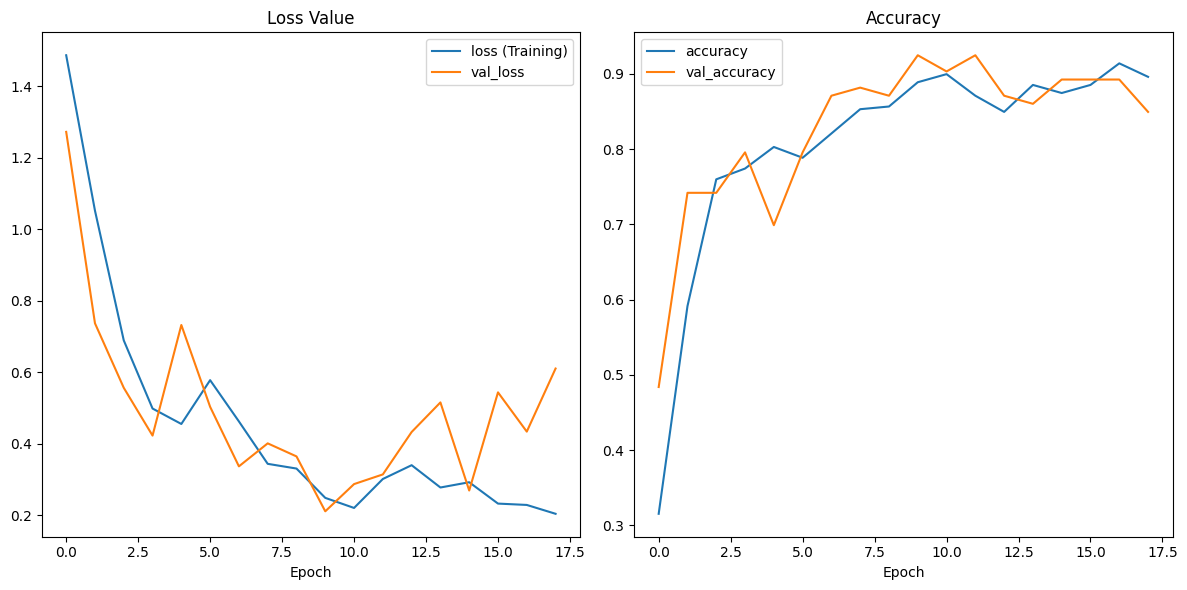

Test loss: 0.19381529092788696
Test accuracy: 0.946236559139785
F1 Score: 0.9414473684210526
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        29
         1.0       0.96      1.00      0.98        22
         2.0       0.85      1.00      0.92        22
         3.0       1.00      0.80      0.89        20

    accuracy                           0.95        93
   macro avg       0.95      0.94      0.94        93
weighted avg       0.95      0.95      0.95        93



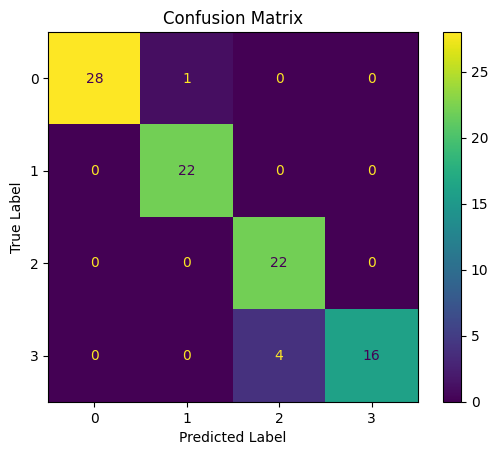

In [9]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=200, strides=10, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=200, strides=10, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=200, strides=10, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=200, strides=10, activation='relu', padding='same', name='conv1d_4_0')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_4_1')(x4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)

    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')

    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)

    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [10]:
# model_name = "1D_AUGnostr_SPEED_4Cnv1Drpt_1Dens_200W_10S_97"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# same as best EASY f+f but branched

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 446, 64)   │      1,344 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 446, 64)   │      1,344 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 446, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 446, 64)   │      2,624 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 223, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 223, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 223, 64)   │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 223, 64)   │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 52, 128)   │    131,200 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 52, 128)   │    131,200 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 52, 128)   │    131,200 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 52, 128)   │    131,200 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 52, 128)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 45, 128)   │    131,200 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 45, 128)   │    131,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 45, 128)   │    131,200 │ dropout_2[0][0] 

 Total params: 1,427,140 (5.44 MB)

 Trainable params: 1,427,140 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy: 0.2924 - loss: 1.3408 - val_accuracy: 0.4516 - val_loss: 1.0476
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6269 - loss: 0.8758 - val_accuracy: 0.7849 - val_loss: 0.5347
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7338 - loss: 0.6846 - val_accuracy: 0.8172 - val_loss: 0.5457
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.5109 - val_accuracy: 0.8387 - val_loss: 0.3662
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8541 - loss: 0.4358 - val_accuracy: 0.8602 - val_loss: 0.3955
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.4265 - val_accuracy: 0.8710 - val_loss: 0.3734
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8706 - loss: 0.3418 - val_accuracy: 0.8387 - val_loss: 0.3364
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.3674 - val_accuracy: 0.7742 - val_loss: 0.7887
Epoch 9/70
9/9 ━━

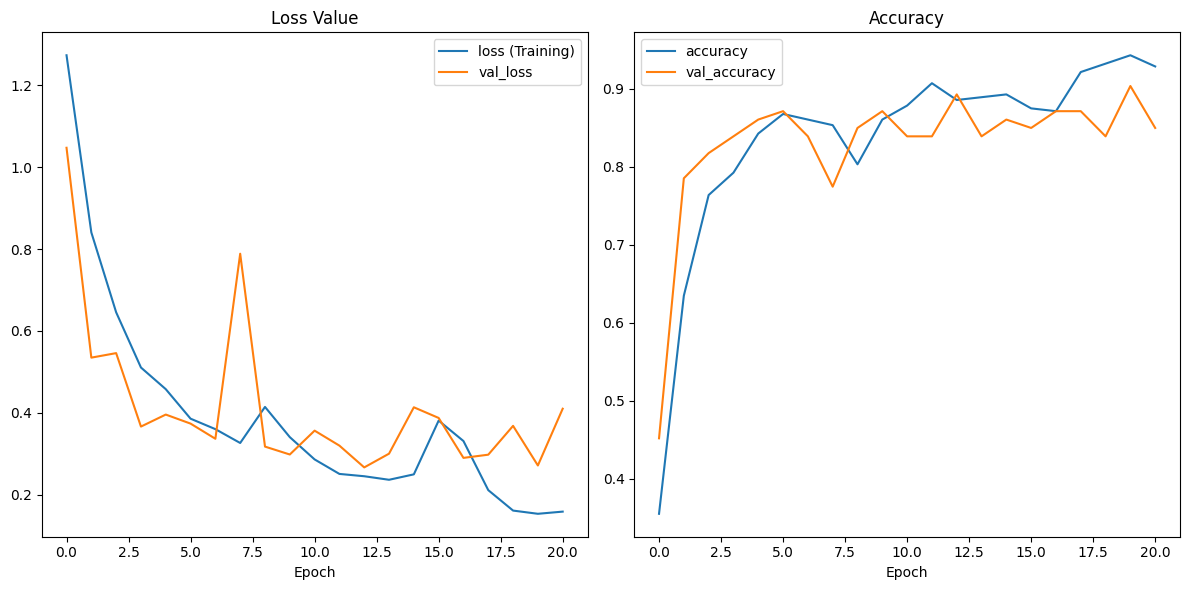

Test loss: 0.23617619276046753
Test accuracy: 0.9032258064516129
F1 Score: 0.8965350877192981
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        29
         1.0       1.00      0.91      0.95        22
         2.0       0.79      1.00      0.88        22
         3.0       0.83      0.75      0.79        20

    accuracy                           0.90        93
   macro avg       0.90      0.90      0.90        93
weighted avg       0.91      0.90      0.90        93



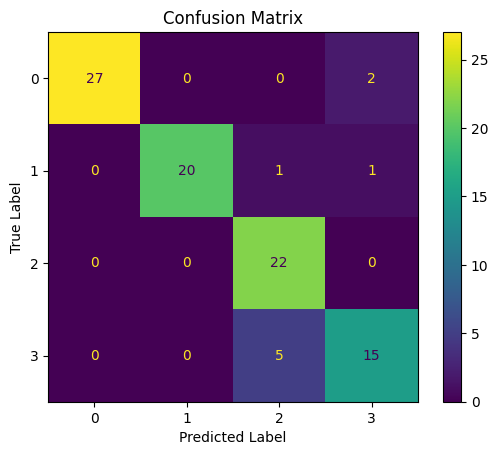

In [11]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv1D(filters=128, kernel_size=8, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=256, kernel_size=4, activation='relu')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(x2)
    x2 = Dropout(rate=0.1)(x2)
    x2 = Conv1D(filters=128, kernel_size=8, activation='relu')(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=64, kernel_size=4, activation='relu')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(x3)
    x3 = Dropout(rate=0.1)(x3)
    x3 = Conv1D(filters=128, kernel_size=8, activation='relu')(x3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=256, kernel_size=4, activation='relu')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(x4)
    x4 = Dropout(rate=0.1)(x4)
    x4 = Conv1D(filters=128, kernel_size=8, activation='relu')(x4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=64, kernel_size=4, activation='relu')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification (adjust if needed)
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [12]:
# model_name = "1D_SPEED_4Cnv_1Dens_20Kern_95"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)